In [92]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot as skplt

import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL

from tensorflow.contrib.learn import DNNClassifier

#from tecnosmartlib import DataObject

In [93]:
#plt.style.use('fivethirtyeight')

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Parameters

In [94]:
root_path = "../"
path_data_raw = root_path + "data/raw/"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "test"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [95]:
dfNoticias = pd.read_pickle(path_data_raw + "/dfNoticias")

# pre procesing

Cleaning data, select clases

In [96]:
print('Selecting useful information...', end='')
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
newClases= []


count = 0
for index, row in dfNoticias.iterrows():
    if (row["Seccion_1"] != None and row["Cuerpo"] != None):
        _map["Cuerpo"].append(row["Cuerpo"]) 
        _map["Seccion"].append(row["Seccion_1"])
        newClases.append(row["Tema_1"])
print('done.')

newClases = np.array(newClases)

Selecting useful information...done.


In [97]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,Deportes,None,None,Torneos ATP,None,None,Tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
2,\nEl Gobierno de Barack Obama ha enviado cuatr...,20140929,07:03,20140929065051,\nLas conversaciones comenzaron el año 2010 y ...,País,Mundo,Mundo,EE.UU.,Relaciones Exteriores,None,Relaciones Exteriores,EE.UU.,Cuba,\nObama ha enviado cuatro solicitudes a Chile ...,fid_noticia
3,\nEste miércoles la Comisión Asesora Presidenc...,20140929,11:37,20140929105234,\nRepresentantes del sector privado acusaron q...,País,None,None,Isapre,None,None,Salud,None,None,\nQuiebre en comisión presidencial de isapres ...,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
5,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929130450,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia


In [98]:
df = pd.DataFrame(_map)
newClases = newClases[~df.duplicated().values]

numberOfDuplicates = df.shape[0]
print('Number of data before dropping duplicates: {}'.format(df.shape[0]))
df = df.drop_duplicates(inplace= False)
df.reset_index(drop=True, inplace= True)
numberOfDuplicates -= df.shape[0]
print('Number of data after dropping duplicates : {}'.format(df.shape[0]))
print('\nNumber of duplicated data : {}'.format(numberOfDuplicates))



Number of data before dropping duplicates: 250339
Number of data after dropping duplicates : 238909

Number of duplicated data : 11430


In [99]:
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y_untransformed = df['Seccion'].reset_index(drop=True)

y_newClases = list(map(lambda x: unidecode.unidecode(x) if x!=None else None, newClases))
y_newClases = np.array(y_newClases)

def remove_accents(a):    
    return unidecode.unidecode(a)

y = y_untransformed.apply(remove_accents)
y = y.values

# Feature Extraccion

### Data representation

TFID calculation

In [100]:
# true calcula features, false carga si ya estan calculadas
calc_tfid = False

features_path = features_path + "tfid_hash28_n1000.p"

if calc_tfid :
    start = time.time()
    print("start")


    spanish_stopwords = stopwords.words('spanish')
    def normalize_text(text):
        return u" ".join([x for x in [y for y in text.lower().strip().split(" ")] 
                          if len(x) > 1 and x not in spanish_stopwords])

    X_untransformed = X_untransformed
    n_docs = X_untransformed.shape[0]
    n_cpu = 20

    batch_size = int(n_docs/n_cpu)

    #'log', "idf":50.0
    wb = wordbatch.WordBatch(normalize_text, 
                             extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                                  "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                                  "idf": 1.0}), procs=n_cpu, n_words=1000, minibatch_size=batch_size)
    wb.dictionary_freeze = True
    word_comment = wb.fit_transform(list(X_untransformed),reset= False)
    # revisar esta normalizacion
    X_transformed = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

    end = time.time()
    print("TFIDF end time :" + str(end - start) )


    X = X_transformed


    #X = X.todense()
    print('Number of features: {}'.format(X.shape[1]))

    pickle.dump( X, open( features_path, "wb" ) )
else:    
    X = pickle.load( open( features_path, "rb" ) )

### filter clases

In [101]:
labels = list(set(y))
labels.remove('Corporativo')
print(labels)

['Mundo', 'Cultura', 'Economia', 'Sociedad', 'Deportes', 'Entretencion', 'Tecnologia', 'Pais']


In [102]:
def filterClases(X,y,umbral):
    labels = list(set(y))
    sizes = [ [label,y[y== label].shape[0]] for label in labels ]
    filter_sizes = list(filter(lambda x:x[1]>umbral ,sizes ))
    names_clases = set( map(lambda x:x[0], filter_sizes ) )
    index = list(map(lambda x: {x}.issubset(names_clases), y ))
    y = y[index]
    X = X[np.nonzero(index)]
    return X,y



In [110]:
y_temas = {}
X_temas = {}
labels_temas = {}
umbral_ejemplos = 100

for key in labels:
    index = y == key
    y_newClases2 = y_newClases[index]
    X2 = X[np.nonzero(index)]

    index = y_newClases2 != None
    y_newClases2 = y_newClases2[index]
    X2 = X2[np.nonzero(index)]
    X_temas[key],y_temas[key] = filterClases(X2,y_newClases2,umbral_ejemplos)
    
    labels_temas[key] = list(set(y_temas[key]))
    
    print("\n"+key)
    print(labels_temas[key])



Mundo
['Pacifico Sur', 'Espana', 'Reino Unido', 'Europa', 'Bolivia', 'EE.UU.', 'Cuba', 'Al Qaeda', 'Accidentes aereos', 'Japon', 'Colombia', 'Alemania', 'Medio Oriente', 'Francia', 'Iran', 'Italia', 'Argentina', 'Africa', 'Paraguay', 'Desastres naturales', 'Peninsula de Corea', 'Sudafrica', 'Irak', 'Brasil', 'India', 'Venezuela', 'Mexico', 'Organismos Internacionales', 'Haiti', 'Afganistan', 'Vaticano', 'Ecuador', 'America Latina', 'Asia', 'Rusia', 'China', 'Peru', 'Uruguay']

Cultura
['Cultura popular', 'Literatura', 'Arte', 'Teatro']

Economia
['Servicios financieros', 'Sueldo minimo', 'Sistema previsional', 'Crisis financiera', 'Organismos internacionales', 'Banco Central', 'Crecimiento', 'Retail', 'Presupuesto', 'Sectores productivos', 'Empresas', 'Materias primas', 'Divisas', 'Bolsas', 'Competitividad', 'Impuestos']

Sociedad
['Homosexualidad', 'Historia', 'Celebraciones', 'Ciencia', 'Religion', 'Mujer', 'Sucesos', 'Ciencias Sociales', 'Medioambiente', 'Fauna', 'Premios Nobel', '

### Output

In [104]:
np.random.seed(42)
train_fraction = 0.8

X_train = {}
y_train = {}
X_test = {}
y_test = {}
train_indices = {}
test_indices = {}

for key in labels:
    train_indices[key] = np.random.choice(X_temas[key].shape[0], round(train_fraction*X_temas[key].shape[0]), replace=False)
    test_indices[key] = np.array(list(set(range(X_temas[key].shape[0])) - set(train_indices)))

    X_train[key] = X_temas[key][train_indices[key]]
    y_train[key] = y_temas[key][train_indices[key]]
    X_test[key] = X_temas[key][test_indices[key]]
    y_test[key] = y_temas[key][test_indices[key]]

In [106]:
weights_train = {}
weights_test = {}

np.random.seed(42)

for key in labels:
    labelsTmp = list(set(y_train[key]))
    nClasses = len(labelsTmp)

    sizes = {label: y_train[key][y_train[key] == label].shape[0] for label in labelsTmp}
    weights = np.asarray([len(y_train[key])/(sizes[label]*nClasses) for label in y_temas[key]])

    weights = weights[:,np.newaxis]
    weights_train[key] = weights[train_indices[key]]
    weights_test[key] = weights[test_indices[key]]

    

# Model

### DNN graph generation

In [112]:
epochs = 14000

# Define the test inputs
def get_train_inputs(key):    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train[key].todense(),'class_weights': weights_train[key]},
                                                  y_train[key][:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=500,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs(key):   
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test[key].todense(),'class_weights': weights_test[key]},
                                                  y_test[key][:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [113]:


tf.set_random_seed(42)
feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=1000)]

classifier = {}
for key in labels:
    classifier[key] = DNNClassifier(                                
                               n_classes=len(labels_temas[key]), label_keys=labels_temas[key], feature_columns=feature_columns,
                               hidden_units=[2000, 1000, 100],
                               dropout=0.5,
                               weight_column_name='class_weights',
                               model_dir = path_model+str(key),
                               config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                               save_checkpoints_secs = None)                           
                              )

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00901a9c88>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/testMundo'}
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00b437e240>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fractio

# Training



In [114]:
#validation_monitor = {}

for key in labels:
    
    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        #input_fn= get_train_inputs(),
        input_fn= get_test_inputs(key),    
        every_n_steps=500,
        #early_stopping_metric="accuracy",#loss
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=2000)

    start = time.time()
    print("start")

    classifier[key].fit(input_fn=get_train_inputs(key), monitors=[validation_monitor], steps=epochs, max_steps=None)

    end = time.time()
    print(key)
    print("Training time :" + str(end - start) )


start
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ../models/testMundo/model.ckpt.
INFO:tensorflow:loss = 3.552081, step = 1
INFO:tensorflow:global_step/sec: 23.3042
INFO:tensorflow:loss = 3.5076427, step = 101 (4.294 sec)
INFO:tensorflow:global_step/sec: 24.0105
INFO:tensorflow:loss = 3.9339418, step = 201 (4.165 sec)
INFO:tensorflow:global_step/sec: 24.0076
INFO:tensorflow:loss = 3.8205552, step = 301 (4.165 sec)
INFO:tensorflow:global_step/sec: 23.7854
INFO:tensorflow:loss = 3.5165675, step = 401 (4.204 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:10:23
INFO:tensorflow:Restoring parameters from ../models/testMundo/model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-09-07-19:10:26
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.027642045, global_step = 1, loss = 3.6377296
INFO:tensorflow:Validation (step 500): loss = 3.6377296, accuracy = 0.027642045, global_step = 1
INFO:tensorflow:Saving checkpoints for 501 

INFO:tensorflow:loss = 3.452985, step = 4301 (4.233 sec)
INFO:tensorflow:global_step/sec: 23.136
INFO:tensorflow:loss = 3.6146069, step = 4401 (4.323 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:13:46
INFO:tensorflow:Restoring parameters from ../models/testMundo/model.ckpt-4001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:13:49
INFO:tensorflow:Saving dict for global step 4001: accuracy = 0.11075102, global_step = 4001, loss = 3.541783
INFO:tensorflow:Validation (step 4500): loss = 3.541783, accuracy = 0.11075102, global_step = 4001
INFO:tensorflow:Saving checkpoints for 4501 into ../models/testMundo/model.ckpt.
INFO:tensorflow:global_step/sec: 12.8186
INFO:tensorflow:loss = 3.509193, step = 4501 (7.808 sec)
INFO:tensorflow:global_step/sec: 23.3056
INFO:tensorflow:loss = 3.4712648, step = 4601 (4.284 sec)
INFO:tensorflow:global_step/sec: 22.9247
INFO:tensorflow:loss = 3.3316548, step = 4701 (4.361 sec)
INFO:tensorflow:global_step/sec: 22.9109
INFO:tensorflow:loss = 

INFO:tensorflow:Validation (step 8500): loss = 2.2950218, accuracy = 0.51608855, global_step = 8001
INFO:tensorflow:Saving checkpoints for 8501 into ../models/testMundo/model.ckpt.
INFO:tensorflow:global_step/sec: 13.0204
INFO:tensorflow:loss = 1.7012088, step = 8501 (7.690 sec)
INFO:tensorflow:global_step/sec: 23.3939
INFO:tensorflow:loss = 1.6128002, step = 8601 (4.264 sec)
INFO:tensorflow:global_step/sec: 23.1651
INFO:tensorflow:loss = 1.5044308, step = 8701 (4.318 sec)
INFO:tensorflow:global_step/sec: 23.2617
INFO:tensorflow:loss = 1.5054238, step = 8801 (4.299 sec)
INFO:tensorflow:global_step/sec: 23.1425
INFO:tensorflow:loss = 1.4321911, step = 8901 (4.320 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:17:31
INFO:tensorflow:Restoring parameters from ../models/testMundo/model.ckpt-8501
INFO:tensorflow:Finished evaluation at 2018-09-07-19:17:34
INFO:tensorflow:Saving dict for global step 8501: accuracy = 0.558364, global_step = 8501, loss = 2.2429945
INFO:tensorflow:Vali

INFO:tensorflow:loss = 0.513139, step = 12601 (4.351 sec)
INFO:tensorflow:global_step/sec: 23.5156
INFO:tensorflow:loss = 0.5185314, step = 12701 (4.252 sec)
INFO:tensorflow:global_step/sec: 22.9329
INFO:tensorflow:loss = 0.44249225, step = 12801 (4.360 sec)
INFO:tensorflow:global_step/sec: 23.3773
INFO:tensorflow:loss = 0.43917906, step = 12901 (4.278 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:20:53
INFO:tensorflow:Restoring parameters from ../models/testMundo/model.ckpt-12501
INFO:tensorflow:Finished evaluation at 2018-09-07-19:20:56
INFO:tensorflow:Saving dict for global step 12501: accuracy = 0.7696088, global_step = 12501, loss = 2.2785375
INFO:tensorflow:Validation (step 13000): loss = 2.2785375, accuracy = 0.7696088, global_step = 12501
INFO:tensorflow:Stopping. Best step: 11000 with loss = 2.078809976577759.
INFO:tensorflow:Saving checkpoints for 13000 into ../models/testMundo/model.ckpt.
INFO:tensorflow:Loss for final step: 0.46478355.
Mundo
Training time :661.4

INFO:tensorflow:Saving checkpoints for 1 into ../models/testEconomia/model.ckpt.
INFO:tensorflow:loss = 2.8251443, step = 1
INFO:tensorflow:global_step/sec: 21.9974
INFO:tensorflow:loss = 2.7360685, step = 101 (4.547 sec)
INFO:tensorflow:global_step/sec: 22.8838
INFO:tensorflow:loss = 2.7220237, step = 201 (4.372 sec)
INFO:tensorflow:global_step/sec: 22.8938
INFO:tensorflow:loss = 2.8233564, step = 301 (4.367 sec)
INFO:tensorflow:global_step/sec: 23.0194
INFO:tensorflow:loss = 2.8478584, step = 401 (4.343 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:24:10
INFO:tensorflow:Restoring parameters from ../models/testEconomia/model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-09-07-19:24:11
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.0651881, global_step = 1, loss = 2.7727096
INFO:tensorflow:Validation (step 500): loss = 2.7727096, accuracy = 0.0651881, global_step = 1
INFO:tensorflow:Saving checkpoints for 501 into ../models/testEconomia/model.ckpt.
INFO:te

INFO:tensorflow:global_step/sec: 23.0729
INFO:tensorflow:loss = 0.0819872, step = 4301 (4.333 sec)
INFO:tensorflow:global_step/sec: 23.4777
INFO:tensorflow:loss = 0.06848462, step = 4401 (4.260 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:27:18
INFO:tensorflow:Restoring parameters from ../models/testEconomia/model.ckpt-4001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:27:18
INFO:tensorflow:Saving dict for global step 4001: accuracy = 0.82025766, global_step = 4001, loss = 1.4062185
INFO:tensorflow:Validation (step 4500): loss = 1.4062185, accuracy = 0.82025766, global_step = 4001
INFO:tensorflow:Saving checkpoints for 4501 into ../models/testEconomia/model.ckpt.
INFO:tensorflow:global_step/sec: 16.8117
INFO:tensorflow:loss = 0.047191333, step = 4501 (5.953 sec)
INFO:tensorflow:global_step/sec: 23.0276
INFO:tensorflow:loss = 0.06742158, step = 4601 (4.337 sec)
INFO:tensorflow:global_step/sec: 22.8408
INFO:tensorflow:loss = 0.041823477, step = 4701 (4.378 sec)
INFO:t

INFO:tensorflow:global_step/sec: 23.1054
INFO:tensorflow:loss = 0.47419313, step = 3401 (4.328 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:30:30
INFO:tensorflow:Restoring parameters from ../models/testSociedad/model.ckpt-3001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:30:31
INFO:tensorflow:Saving dict for global step 3001: accuracy = 0.6982313, global_step = 3001, loss = 1.6163025
INFO:tensorflow:Validation (step 3500): loss = 1.6163025, accuracy = 0.6982313, global_step = 3001
INFO:tensorflow:Saving checkpoints for 3501 into ../models/testSociedad/model.ckpt.
INFO:tensorflow:global_step/sec: 15.4526
INFO:tensorflow:loss = 0.4413724, step = 3501 (6.482 sec)
INFO:tensorflow:global_step/sec: 22.8726
INFO:tensorflow:loss = 0.3612811, step = 3601 (4.361 sec)
INFO:tensorflow:global_step/sec: 23.0858
INFO:tensorflow:loss = 0.3510243, step = 3701 (4.333 sec)
INFO:tensorflow:global_step/sec: 22.7653
INFO:tensorflow:loss = 0.27364072, step = 3801 (4.392 sec)
INFO:tensorf

INFO:tensorflow:Starting evaluation at 2018-09-07-19:34:14
INFO:tensorflow:Restoring parameters from ../models/testDeportes/model.ckpt-2001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:34:21
INFO:tensorflow:Saving dict for global step 2001: accuracy = 0.056373324, global_step = 2001, loss = 3.4862845
INFO:tensorflow:Validation (step 2500): loss = 3.4862845, accuracy = 0.056373324, global_step = 2001
INFO:tensorflow:Saving checkpoints for 2501 into ../models/testDeportes/model.ckpt.
INFO:tensorflow:global_step/sec: 8.572
INFO:tensorflow:loss = 4.377878, step = 2501 (11.671 sec)
INFO:tensorflow:global_step/sec: 22.0201
INFO:tensorflow:loss = 3.7930455, step = 2601 (4.538 sec)
INFO:tensorflow:global_step/sec: 22.0246
INFO:tensorflow:loss = 3.101299, step = 2701 (4.539 sec)
INFO:tensorflow:global_step/sec: 21.8738
INFO:tensorflow:loss = 4.0240855, step = 2801 (4.573 sec)
INFO:tensorflow:global_step/sec: 21.3611
INFO:tensorflow:loss = 3.3071775, step = 2901 (4.683 sec)
INFO:tensorfl

INFO:tensorflow:Validation (step 6500): loss = 2.761362, accuracy = 0.30771613, global_step = 6001
INFO:tensorflow:Saving checkpoints for 6501 into ../models/testDeportes/model.ckpt.
INFO:tensorflow:global_step/sec: 8.65512
INFO:tensorflow:loss = 2.025148, step = 6501 (11.555 sec)
INFO:tensorflow:global_step/sec: 21.9066
INFO:tensorflow:loss = 2.1831062, step = 6601 (4.561 sec)
INFO:tensorflow:global_step/sec: 21.6832
INFO:tensorflow:loss = 2.1849203, step = 6701 (4.612 sec)
INFO:tensorflow:global_step/sec: 21.9739
INFO:tensorflow:loss = 2.6474936, step = 6801 (4.551 sec)
INFO:tensorflow:global_step/sec: 22.2715
INFO:tensorflow:loss = 2.1325967, step = 6901 (4.490 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:38:43
INFO:tensorflow:Restoring parameters from ../models/testDeportes/model.ckpt-6501
INFO:tensorflow:Finished evaluation at 2018-09-07-19:38:49
INFO:tensorflow:Saving dict for global step 6501: accuracy = 0.3459121, global_step = 6501, loss = 2.6854162
INFO:tensorflo

INFO:tensorflow:loss = 1.0226518, step = 10601 (4.605 sec)
INFO:tensorflow:global_step/sec: 21.9774
INFO:tensorflow:loss = 1.1011698, step = 10701 (4.550 sec)
INFO:tensorflow:global_step/sec: 21.8235
INFO:tensorflow:loss = 1.1107168, step = 10801 (4.582 sec)
INFO:tensorflow:global_step/sec: 21.8694
INFO:tensorflow:loss = 1.0911473, step = 10901 (4.572 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:42:41
INFO:tensorflow:Restoring parameters from ../models/testDeportes/model.ckpt-10501
INFO:tensorflow:Finished evaluation at 2018-09-07-19:42:47
INFO:tensorflow:Saving dict for global step 10501: accuracy = 0.6273478, global_step = 10501, loss = 2.392483
INFO:tensorflow:Validation (step 11000): loss = 2.392483, accuracy = 0.6273478, global_step = 10501
INFO:tensorflow:Saving checkpoints for 11001 into ../models/testDeportes/model.ckpt.
INFO:tensorflow:global_step/sec: 8.83475
INFO:tensorflow:loss = 0.9331557, step = 11001 (11.325 sec)
INFO:tensorflow:global_step/sec: 22.2369
INFO

INFO:tensorflow:loss = 2.2764533, step = 1101 (4.551 sec)
INFO:tensorflow:global_step/sec: 21.4653
INFO:tensorflow:loss = 2.7079298, step = 1201 (4.659 sec)
INFO:tensorflow:global_step/sec: 21.7653
INFO:tensorflow:loss = 2.8963912, step = 1301 (4.593 sec)
INFO:tensorflow:global_step/sec: 21.8077
INFO:tensorflow:loss = 2.785752, step = 1401 (4.587 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:46:37
INFO:tensorflow:Restoring parameters from ../models/testEntretencion/model.ckpt-1001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:46:40
INFO:tensorflow:Saving dict for global step 1001: accuracy = 0.23799454, global_step = 1001, loss = 2.601342
INFO:tensorflow:Validation (step 1500): loss = 2.601342, accuracy = 0.23799454, global_step = 1001
INFO:tensorflow:Saving checkpoints for 1501 into ../models/testEntretencion/model.ckpt.
INFO:tensorflow:global_step/sec: 12.4149
INFO:tensorflow:loss = 2.1368363, step = 1501 (8.059 sec)
INFO:tensorflow:global_step/sec: 21.6649
INFO:te

INFO:tensorflow:global_step/sec: 22.3431
INFO:tensorflow:loss = 0.3999008, step = 5401 (4.476 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:50:08
INFO:tensorflow:Restoring parameters from ../models/testEntretencion/model.ckpt-5001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:50:10
INFO:tensorflow:Saving dict for global step 5001: accuracy = 0.6792112, global_step = 5001, loss = 1.9125396
INFO:tensorflow:Validation (step 5500): loss = 1.9125396, accuracy = 0.6792112, global_step = 5001
INFO:tensorflow:Saving checkpoints for 5501 into ../models/testEntretencion/model.ckpt.
INFO:tensorflow:global_step/sec: 13.1745
INFO:tensorflow:loss = 0.39801615, step = 5501 (7.597 sec)
INFO:tensorflow:global_step/sec: 21.8894
INFO:tensorflow:loss = 0.39325443, step = 5601 (4.561 sec)
INFO:tensorflow:global_step/sec: 21.299
INFO:tensorflow:loss = 0.39680737, step = 5701 (4.696 sec)
INFO:tensorflow:global_step/sec: 22.0006
INFO:tensorflow:loss = 0.37077612, step = 5801 (4.545 sec)
INF

INFO:tensorflow:loss = 0.037969053, step = 3401 (4.565 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-19:53:33
INFO:tensorflow:Restoring parameters from ../models/testTecnologia/model.ckpt-3001
INFO:tensorflow:Finished evaluation at 2018-09-07-19:53:34
INFO:tensorflow:Saving dict for global step 3001: accuracy = 0.86222714, global_step = 3001, loss = 0.7561144
INFO:tensorflow:Validation (step 3500): loss = 0.7561144, accuracy = 0.86222714, global_step = 3001
INFO:tensorflow:Saving checkpoints for 3501 into ../models/testTecnologia/model.ckpt.
INFO:tensorflow:global_step/sec: 15.5842
INFO:tensorflow:loss = 0.025817506, step = 3501 (6.422 sec)
INFO:tensorflow:global_step/sec: 22.1527
INFO:tensorflow:loss = 0.0281541, step = 3601 (4.510 sec)
INFO:tensorflow:global_step/sec: 21.7976
INFO:tensorflow:loss = 0.02042062, step = 3701 (4.588 sec)
INFO:tensorflow:global_step/sec: 21.8601
INFO:tensorflow:loss = 0.020355243, step = 3801 (4.574 sec)
INFO:tensorflow:global_step/sec: 21.8459
I

INFO:tensorflow:Starting evaluation at 2018-09-07-19:57:09
INFO:tensorflow:Restoring parameters from ../models/testPais/model.ckpt-1501
INFO:tensorflow:Finished evaluation at 2018-09-07-19:57:15
INFO:tensorflow:Saving dict for global step 1501: accuracy = 0.025611743, global_step = 1501, loss = 3.9491627
INFO:tensorflow:Validation (step 2000): loss = 3.9491627, accuracy = 0.025611743, global_step = 1501
INFO:tensorflow:Saving checkpoints for 2001 into ../models/testPais/model.ckpt.
INFO:tensorflow:global_step/sec: 9.38538
INFO:tensorflow:loss = 3.7724178, step = 2001 (10.657 sec)
INFO:tensorflow:global_step/sec: 21.7073
INFO:tensorflow:loss = 4.618408, step = 2101 (4.604 sec)
INFO:tensorflow:global_step/sec: 21.5378
INFO:tensorflow:loss = 3.904357, step = 2201 (4.643 sec)
INFO:tensorflow:global_step/sec: 22.2148
INFO:tensorflow:loss = 4.264955, step = 2301 (4.503 sec)
INFO:tensorflow:global_step/sec: 21.6687
INFO:tensorflow:loss = 3.5068233, step = 2401 (4.614 sec)
INFO:tensorflow:Star

INFO:tensorflow:Saving checkpoints for 6001 into ../models/testPais/model.ckpt.
INFO:tensorflow:global_step/sec: 8.75633
INFO:tensorflow:loss = 3.8008478, step = 6001 (11.425 sec)
INFO:tensorflow:global_step/sec: 21.8803
INFO:tensorflow:loss = 3.9970708, step = 6101 (4.566 sec)
INFO:tensorflow:global_step/sec: 22.0473
INFO:tensorflow:loss = 3.7131274, step = 6201 (4.536 sec)
INFO:tensorflow:global_step/sec: 21.6606
INFO:tensorflow:loss = 3.9692047, step = 6301 (4.616 sec)
INFO:tensorflow:global_step/sec: 21.7287
INFO:tensorflow:loss = 3.1081893, step = 6401 (4.603 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-20:01:37
INFO:tensorflow:Restoring parameters from ../models/testPais/model.ckpt-6001
INFO:tensorflow:Finished evaluation at 2018-09-07-20:01:43
INFO:tensorflow:Saving dict for global step 6001: accuracy = 0.10530051, global_step = 6001, loss = 3.7574666
INFO:tensorflow:Validation (step 6500): loss = 3.7574666, accuracy = 0.10530051, global_step = 6001
INFO:tensorflow:Sav

INFO:tensorflow:global_step/sec: 21.444
INFO:tensorflow:loss = 2.406846, step = 10301 (4.663 sec)
INFO:tensorflow:global_step/sec: 21.6364
INFO:tensorflow:loss = 2.2740316, step = 10401 (4.620 sec)
INFO:tensorflow:Starting evaluation at 2018-09-07-20:05:34
INFO:tensorflow:Restoring parameters from ../models/testPais/model.ckpt-10001
INFO:tensorflow:Finished evaluation at 2018-09-07-20:05:40
INFO:tensorflow:Saving dict for global step 10001: accuracy = 0.41333216, global_step = 10001, loss = 2.7988856
INFO:tensorflow:Validation (step 10500): loss = 2.7988856, accuracy = 0.41333216, global_step = 10001
INFO:tensorflow:Saving checkpoints for 10501 into ../models/testPais/model.ckpt.
INFO:tensorflow:global_step/sec: 8.86975
INFO:tensorflow:loss = 2.379607, step = 10501 (11.283 sec)
INFO:tensorflow:global_step/sec: 21.6384
INFO:tensorflow:loss = 2.2636902, step = 10601 (4.614 sec)
INFO:tensorflow:global_step/sec: 21.782
INFO:tensorflow:loss = 2.2206428, step = 10701 (4.591 sec)
INFO:tensorf

# Evaluation performance


In [115]:
pred_test = {}
y_test_hat = {}
y_test_hat = {}
acc = {}

for key in labels:

    def input_fn_evaluate():
        dataset = {'x': tf.constant(X_test[key].todense())}    
        return dataset

    pred_test[key] = classifier[key].predict_classes(input_fn=input_fn_evaluate)
    y_test_hat[key] = np.asarray([x.decode('UTF-8') for x in list(pred_test[key])])
    y_test_hat[key] = y_test_hat[key].astype(str)
    acc[key] = accuracy_score(y_true=y_test[key], y_pred=y_test_hat[key])


INFO:tensorflow:Restoring parameters from ../models/testMundo/model.ckpt-13000
INFO:tensorflow:Restoring parameters from ../models/testCultura/model.ckpt-3500
INFO:tensorflow:Restoring parameters from ../models/testEconomia/model.ckpt-5000
INFO:tensorflow:Restoring parameters from ../models/testSociedad/model.ckpt-5000
INFO:tensorflow:Restoring parameters from ../models/testDeportes/model.ckpt-13500
INFO:tensorflow:Restoring parameters from ../models/testEntretencion/model.ckpt-6000
INFO:tensorflow:Restoring parameters from ../models/testTecnologia/model.ckpt-5500
INFO:tensorflow:Restoring parameters from ../models/testPais/model.ckpt-14000


## Mundo

## Accuracy in test: 68.21302001851792 

/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


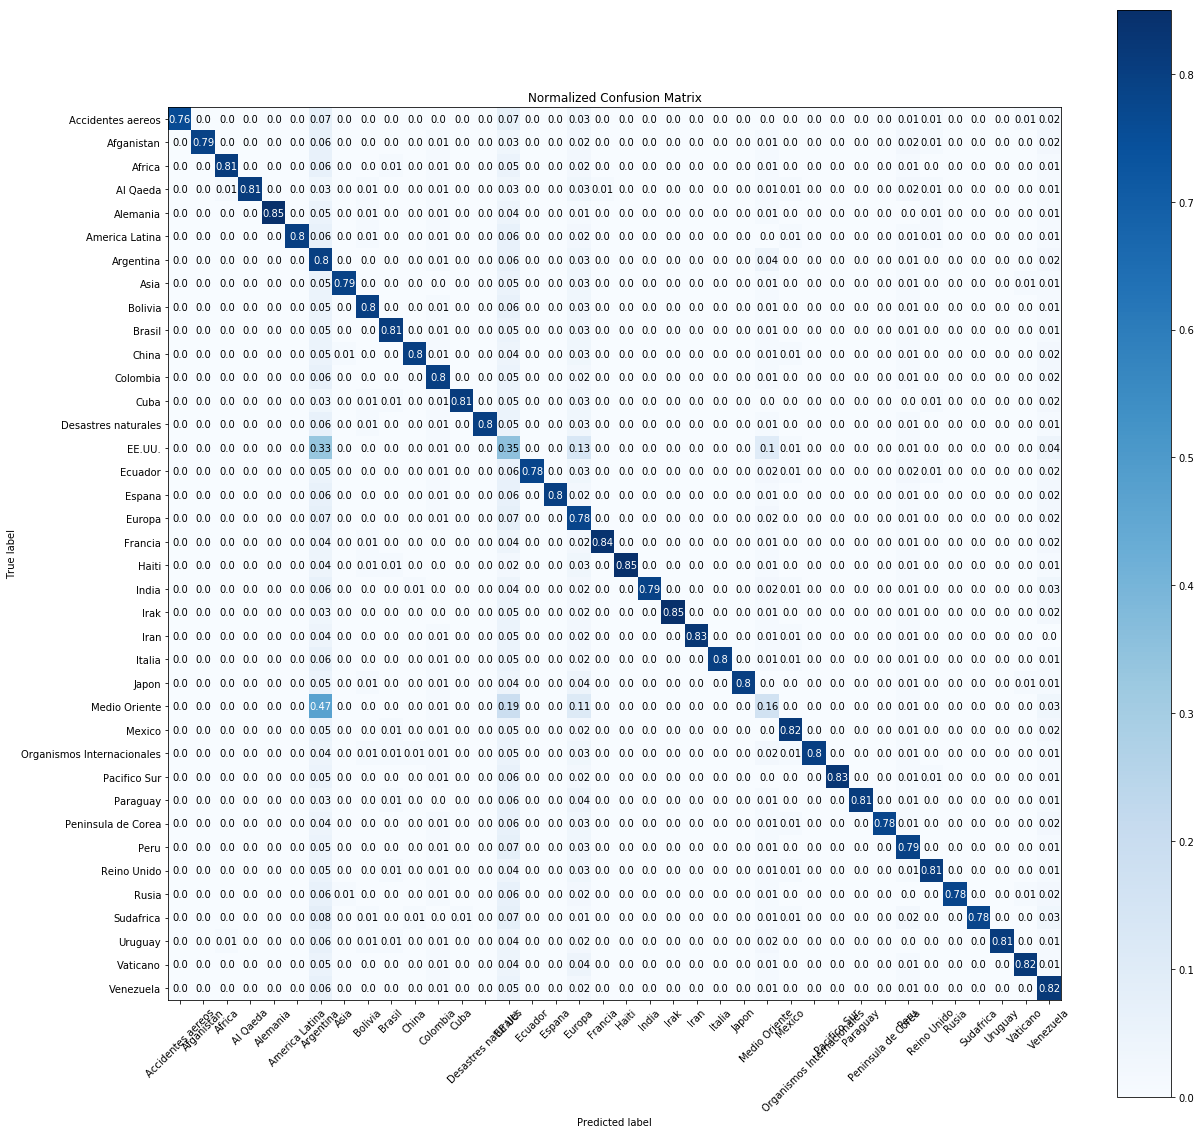

## Cultura

## Accuracy in test: 88.77166541070083 

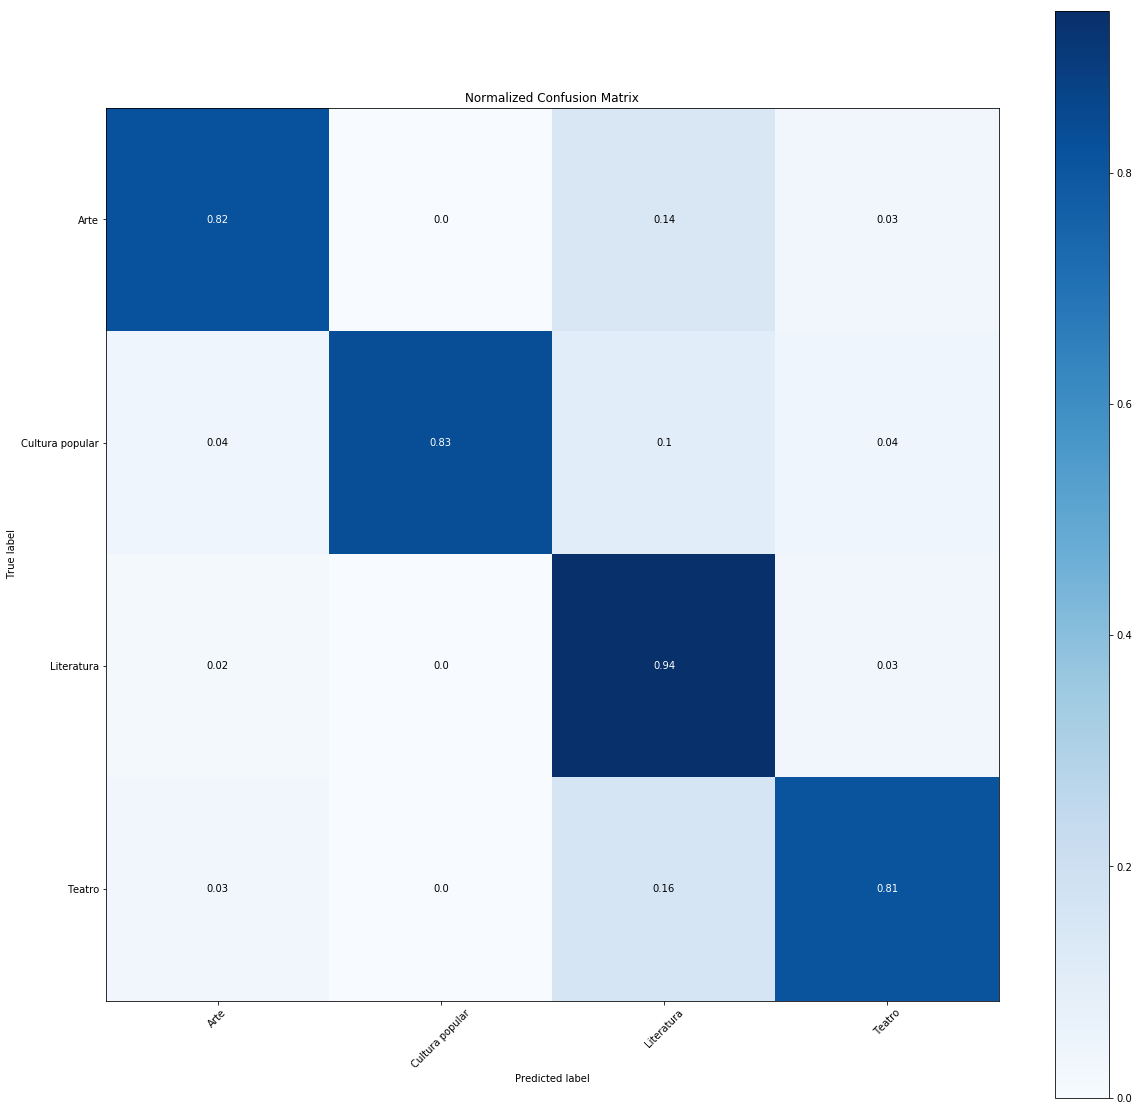

## Economia

## Accuracy in test: 82.58417364553068 

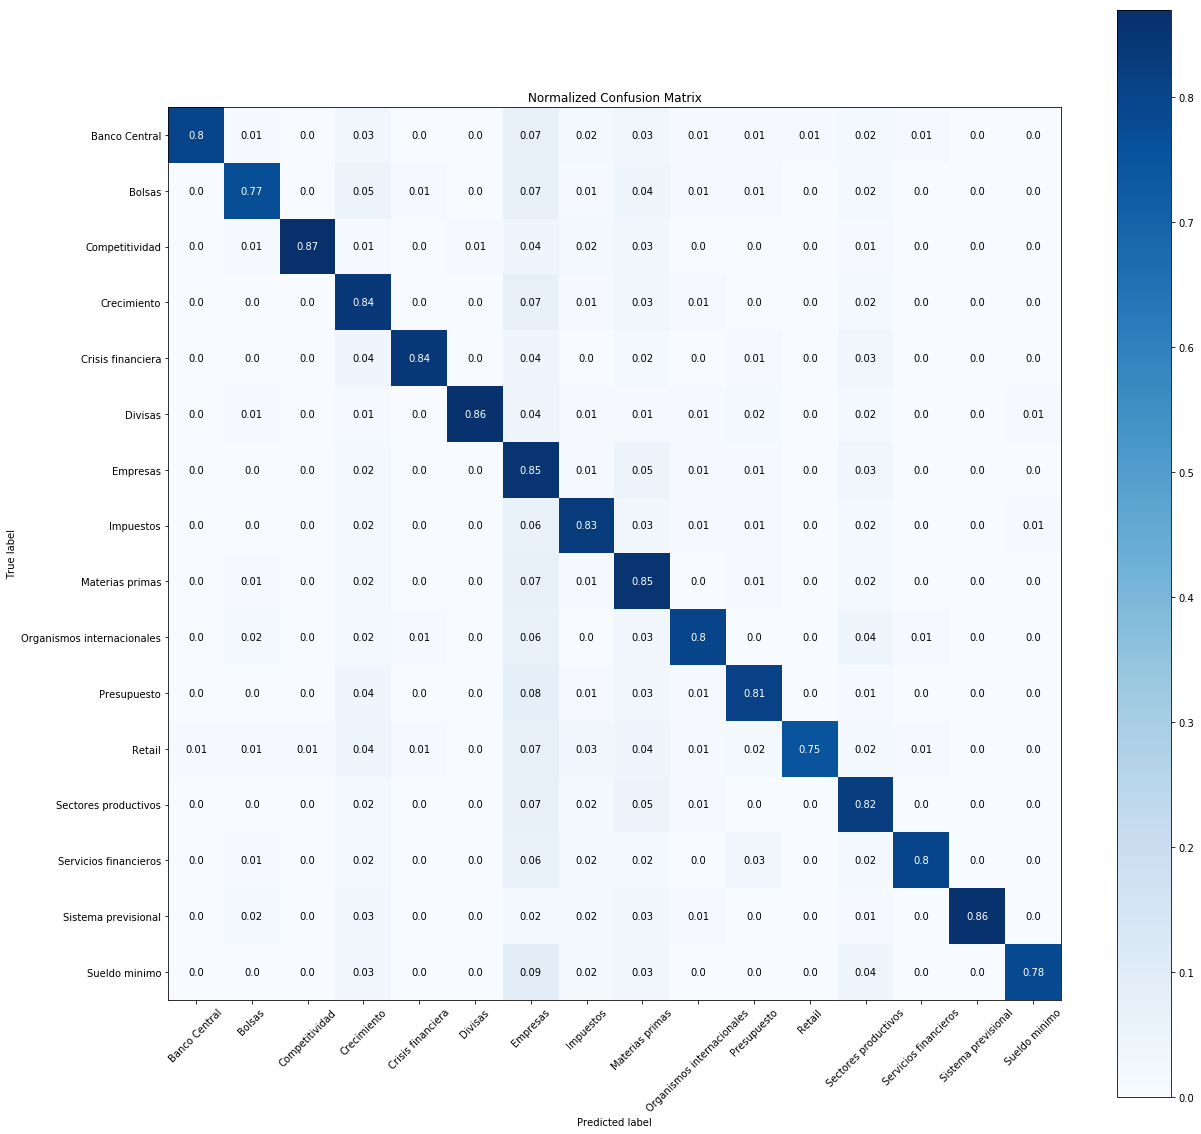

## Sociedad

## Accuracy in test: 84.38056776339232 

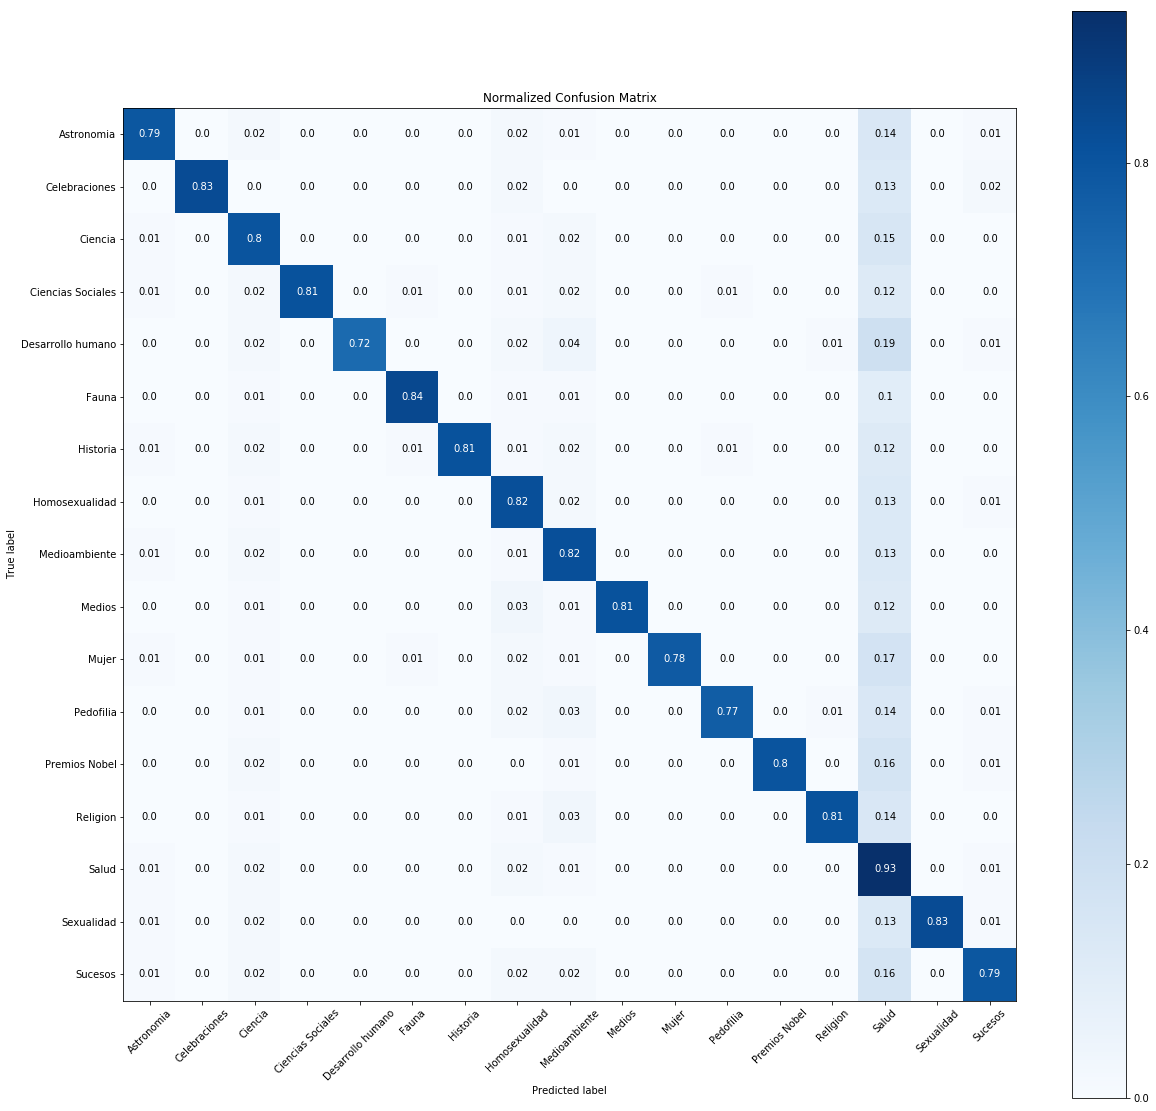

## Deportes

## Accuracy in test: 24.310809921705374 

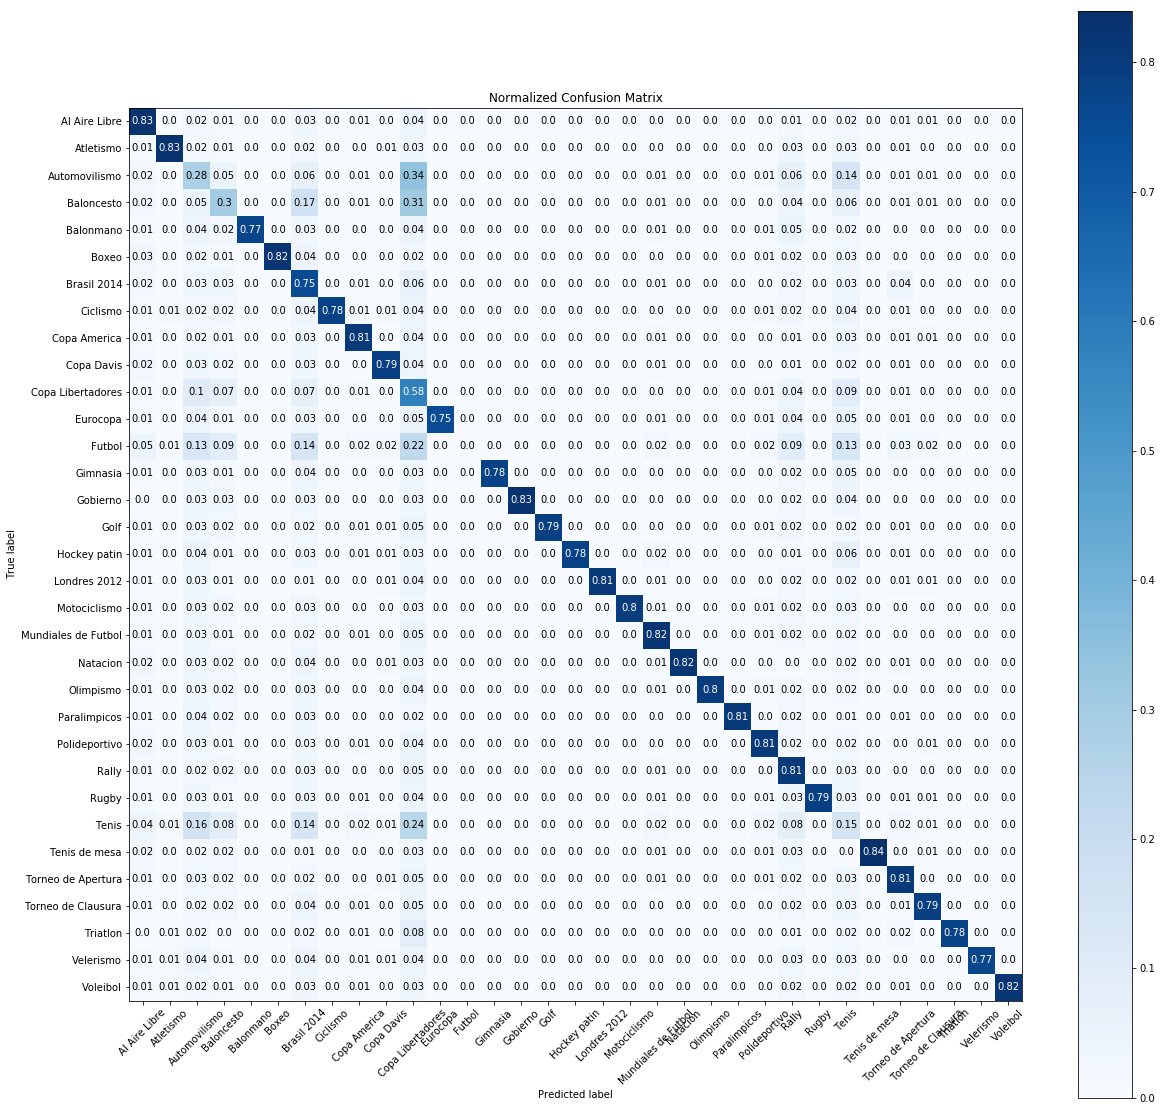

## Entretencion

## Accuracy in test: 35.23636861189027 

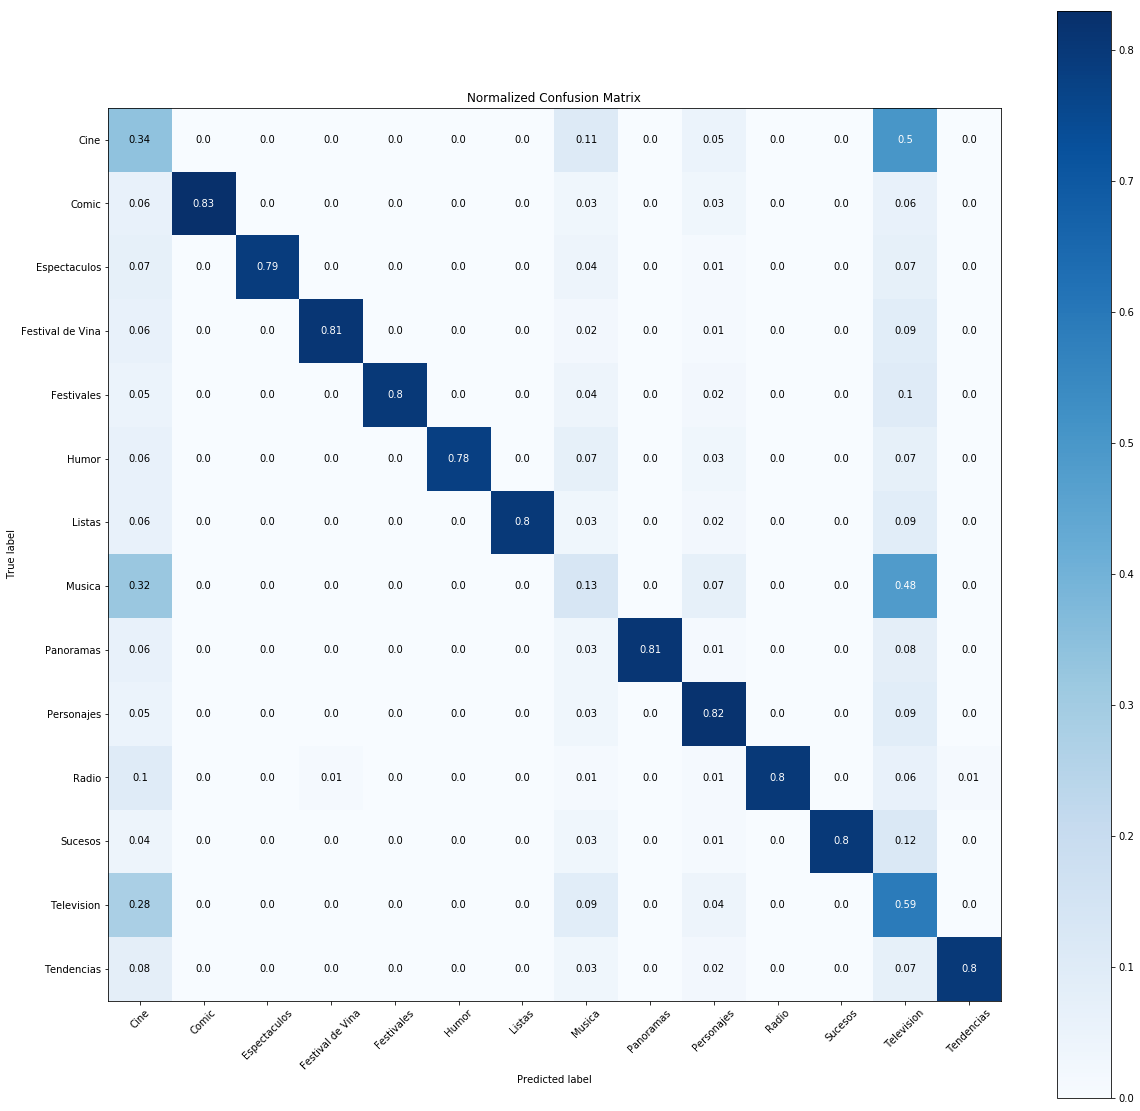

## Tecnologia

## Accuracy in test: 87.7606788436646 

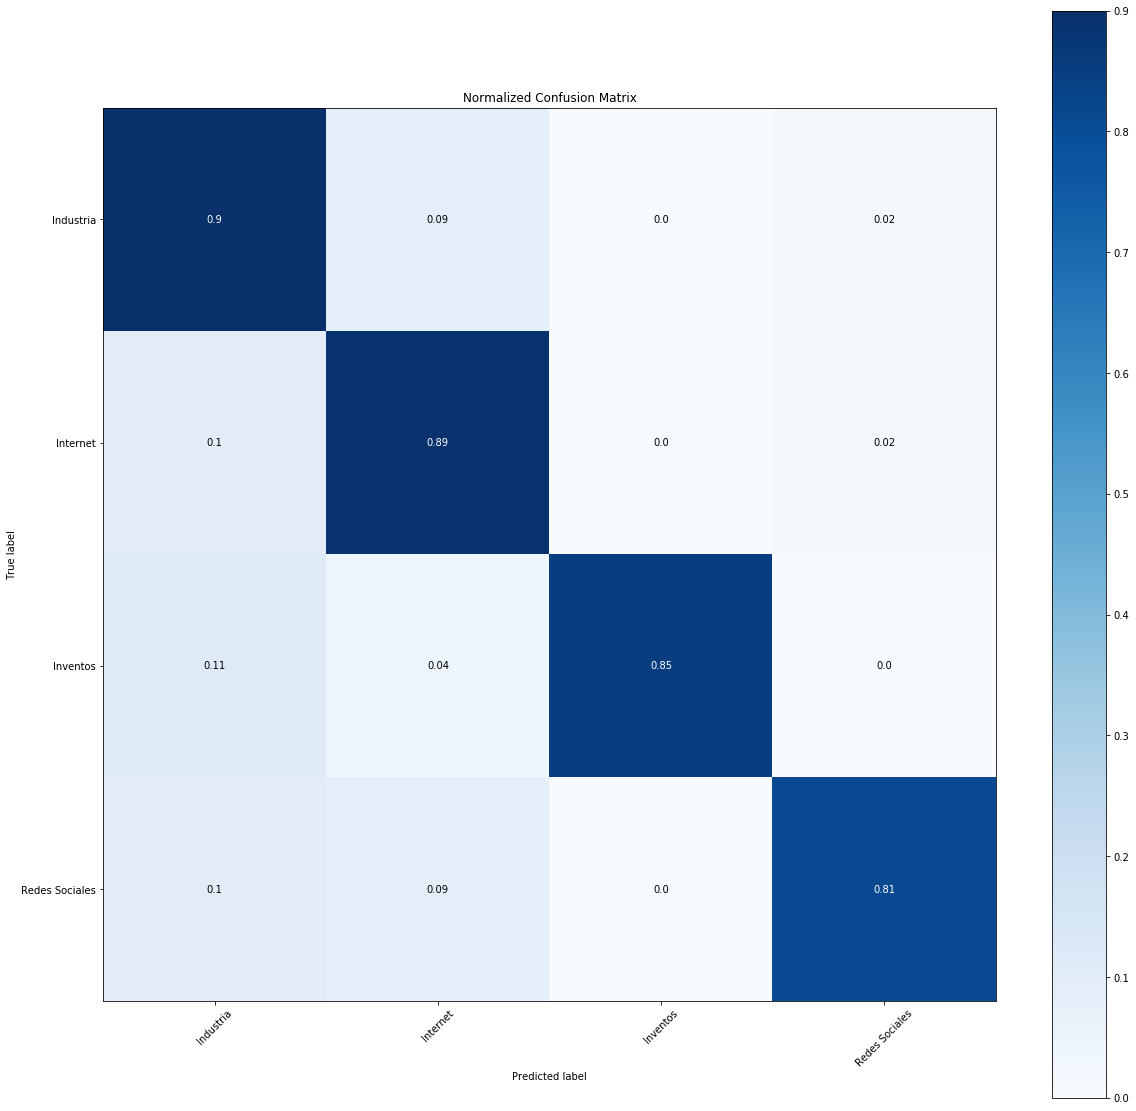

## Pais

## Accuracy in test: 22.5518367126688 

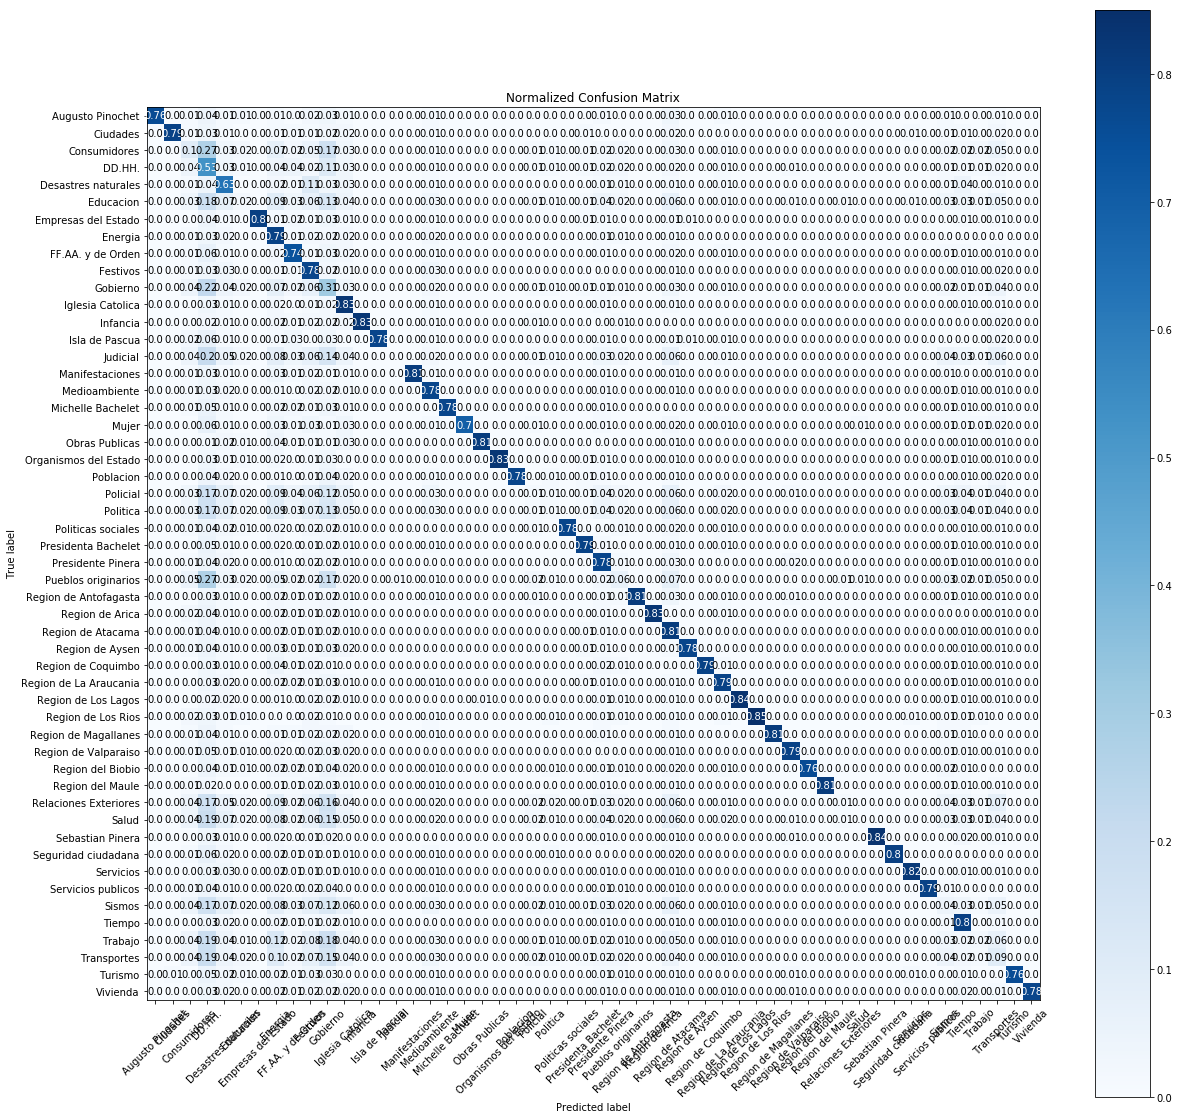

In [118]:
for key in labels:
    display(Markdown('## ' + key))
    display(Markdown('## Accuracy in test: {} '.format(acc[key]*100)))    
    skplt.metrics.plot_confusion_matrix(y_test[key], y_test_hat[key],normalize=True,figsize=(20,20))
    plt.xticks(rotation=45)
    plt.show()

    #print('Accuracy in test: {}'.format(acc))


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


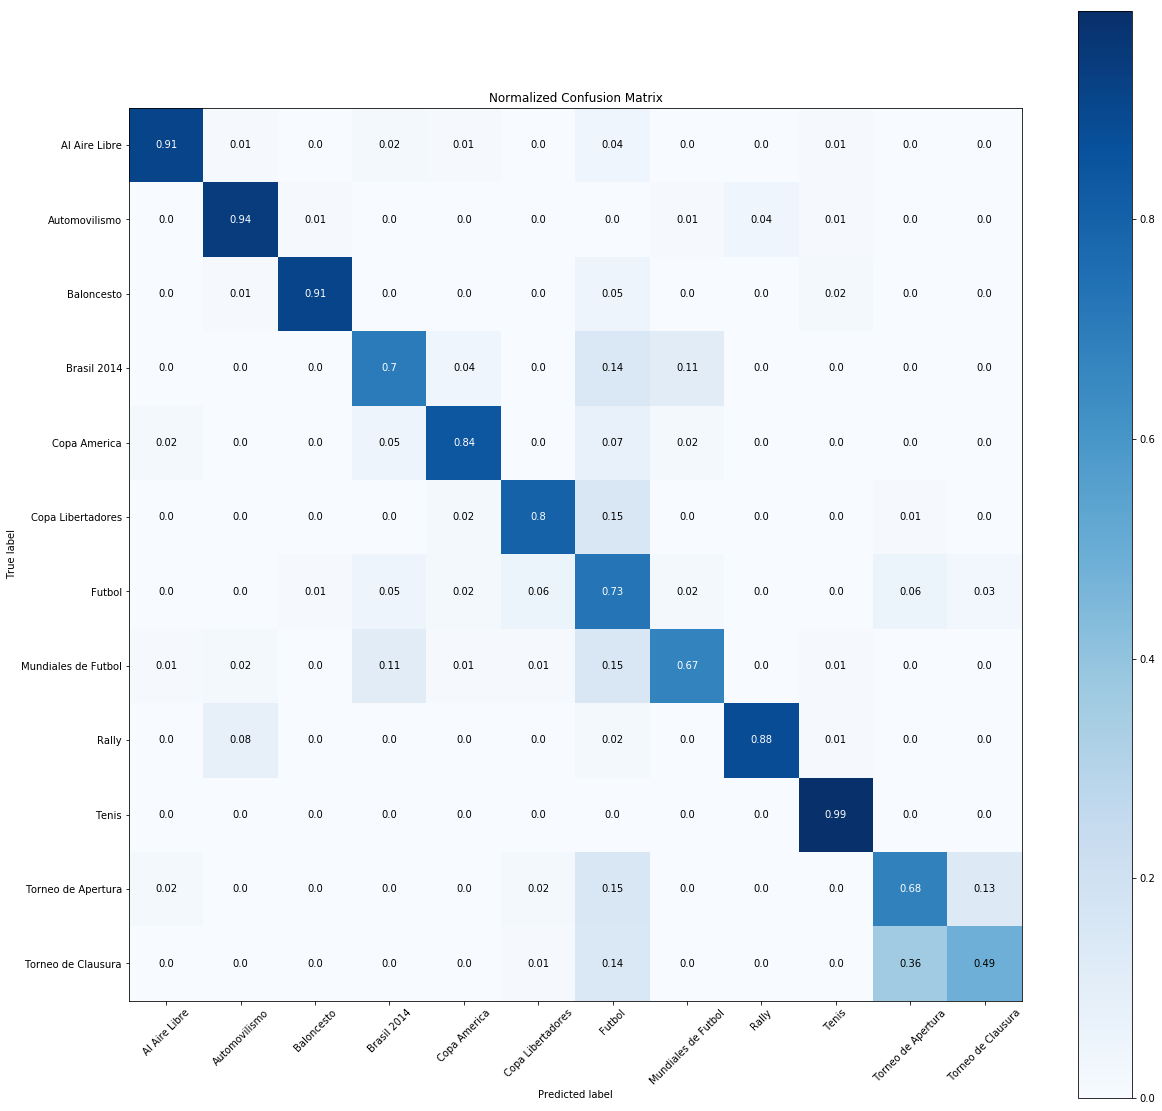

In [21]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize=True,figsize=(20,20))
plt.xticks(rotation=45)
plt.show()
